<a href="https://colab.research.google.com/github/VKSi/2021_01_NeuralNetworks_Intro/blob/main/HW_6_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение в искусственные нейронные сети
# Урок 6. Сегментация

## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 
        Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?
    </li>
    <li>*Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview</li>
    <li>*Сделайте свою реализацию U-Net на TensorFlow</li>
</ol>

# Решение

## Подготовка данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/NeuralNetwork/Lesson6/'

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-7kgaomb2
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-7kgaomb2
  Created wheel for tensorflow-examples: filename=tensorflow_examples-ee198ec873148a5df3fd6eedb8d396613164ead7_-cp36-none-any.whl size=215217 sha256=aa21cc7fe70f944eb7f026a0fecc23483e9100caae486fd4f0fda92a0c01daf8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ougjbrlz/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
pip install tensorflow-datasets

In [ ]:
import tensorflow as tf
print(tf.__version__)
msg = tf.constant('TensorFlow 2.0 Hello World')
tf.print(msg)

2.4.1
TensorFlow 2.0 Hello World


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

import tensorflow as tf
# tf.config.experimental.set_visible_devices([], 'GPU')

### Знакомимся с датасетом

In [ ]:
dataset, info = tfds.load('caltech_birds2010', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2010/0.1.1.incompleteACV70J/caltech_birds2010-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2010/0.1.1.incompleteACV70J/caltech_birds2010-test.tfrecord
Dataset caltech_birds2010 downloaded and prepared to /root/tensorflow_datasets/caltech_birds2010/0.1.1. Subsequent calls will reuse this data.


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  # input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask



In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

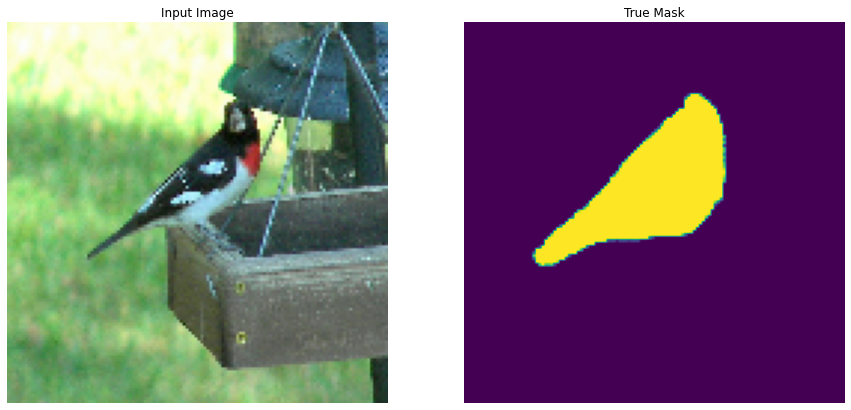

In [ ]:
for image, mask in train.take(11):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Строим базовую сеть

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

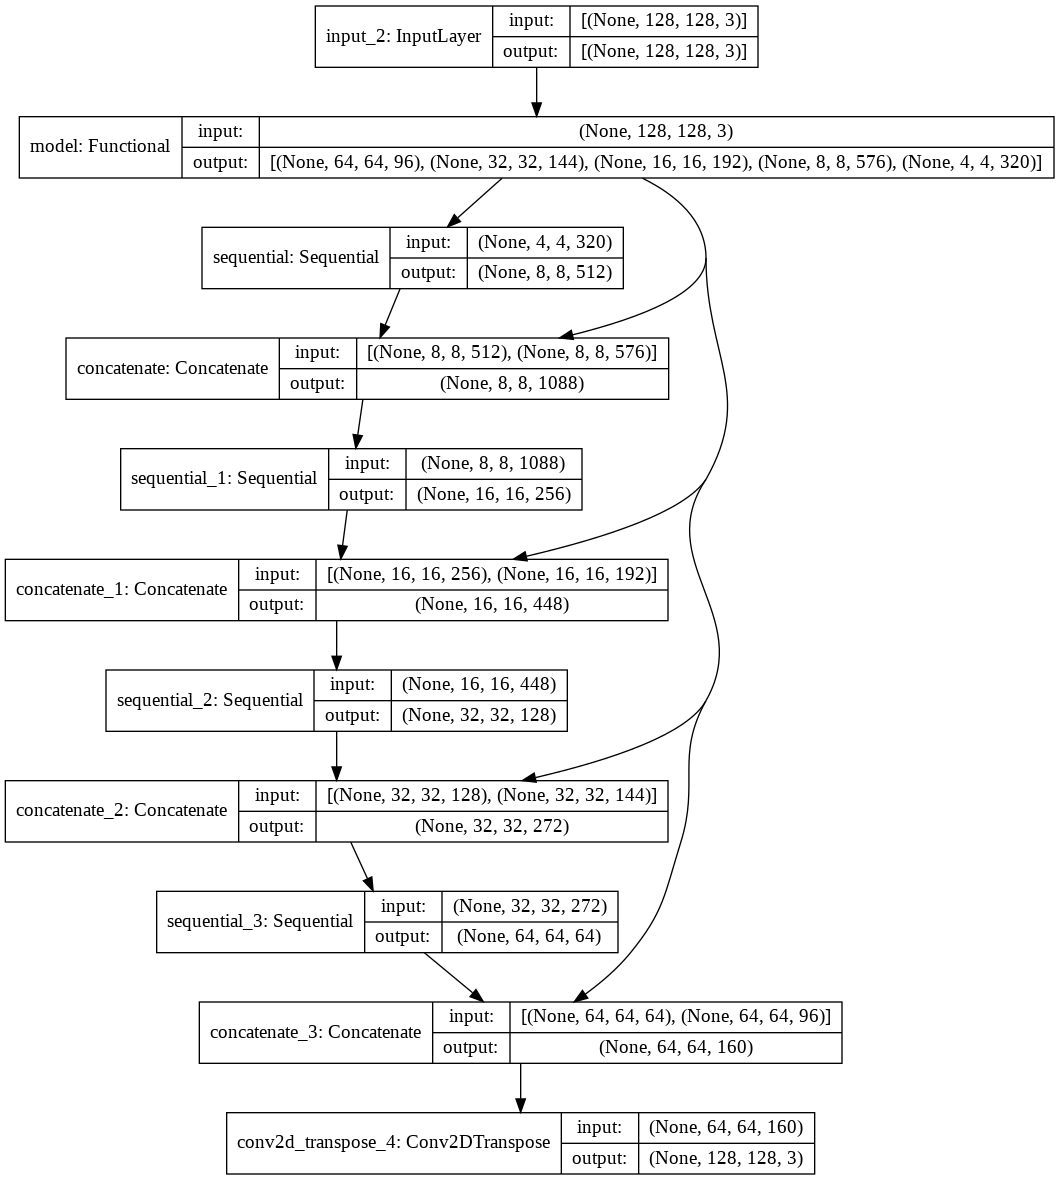

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


## Смотрим предсказание базовой (предобученной) сети, без обуыения на наших данных

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

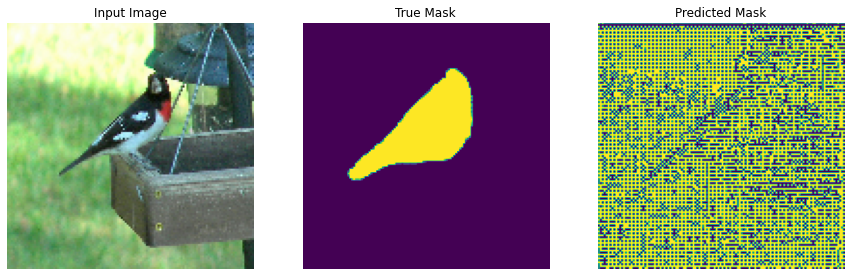

In [ ]:
show_predictions()

## Обучаем сеть

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

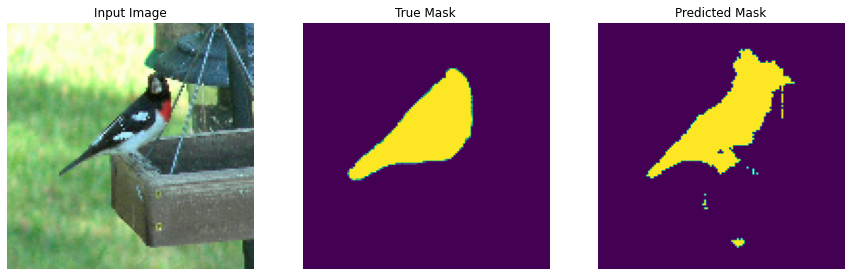


Sample Prediction after epoch 5



In [ ]:
EPOCHS = 5 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

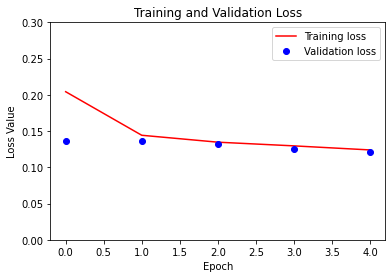

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.3])
plt.legend()
plt.show()

In [ ]:
loss

[0.20431479811668396,
 0.1442173421382904,
 0.134685218334198,
 0.12959080934524536,
 0.12398649007081985]

In [ ]:
val_loss

[0.1356569081544876,
 0.13619591295719147,
 0.13175252079963684,
 0.1252129077911377,
 0.12137914448976517]

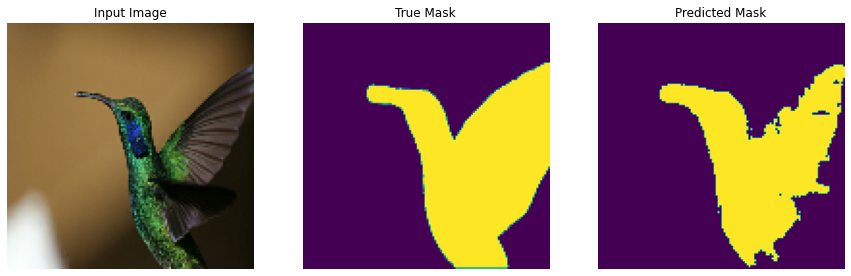

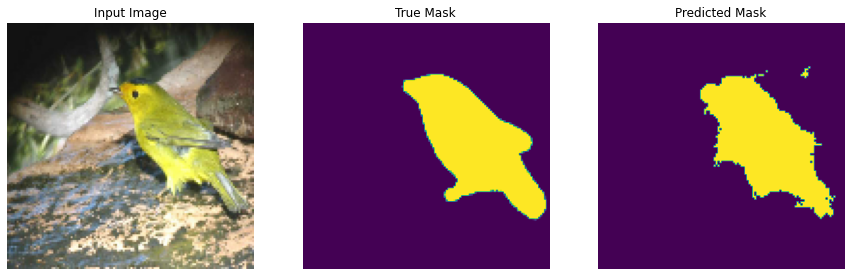

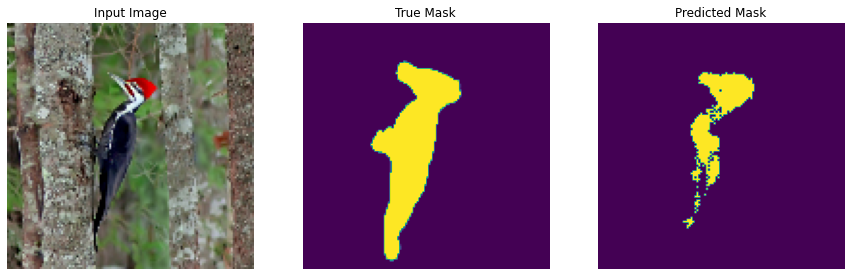

In [ ]:
show_predictions(test_dataset, 3)

## Увеличим количество эпох

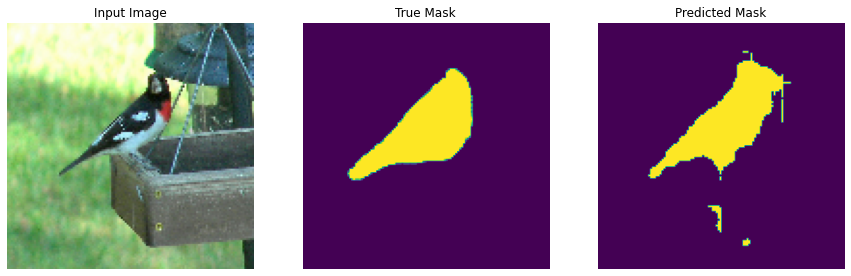


Sample Prediction after epoch 10



In [ ]:
EPOCHS = 10 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

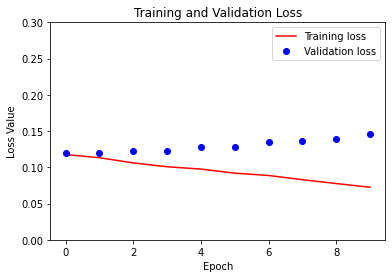

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.3])
plt.legend()
plt.show()

In [ ]:
loss

[0.11763004213571548,
 0.11324644833803177,
 0.10607532411813736,
 0.10079000145196915,
 0.09754657745361328,
 0.09194053709506989,
 0.08874841779470444,
 0.0829082652926445,
 0.07764098048210144,
 0.07254071533679962]

In [ ]:
val_loss

[0.11992357671260834,
 0.12013532221317291,
 0.12233802676200867,
 0.12239880114793777,
 0.1280171126127243,
 0.12867893278598785,
 0.1344592422246933,
 0.13578073680400848,
 0.1392887830734253,
 0.14575985074043274]

In [ ]:
val_accuracy = model_history.history['val_accuracy']
val_accuracy

[0.947583794593811,
 0.9477676153182983,
 0.9478347301483154,
 0.9483803510665894,
 0.9487187266349792,
 0.9475896954536438,
 0.9466978311538696,
 0.9481736421585083,
 0.9471315741539001,
 0.946816623210907]

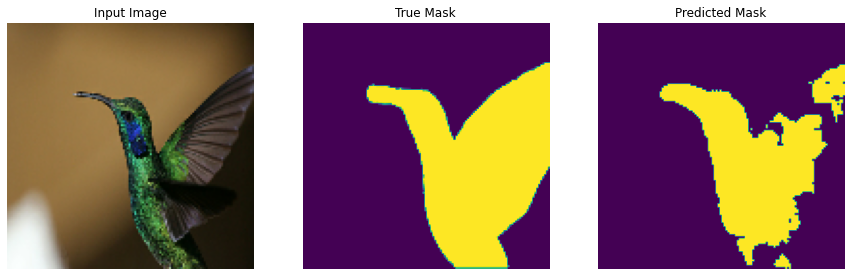

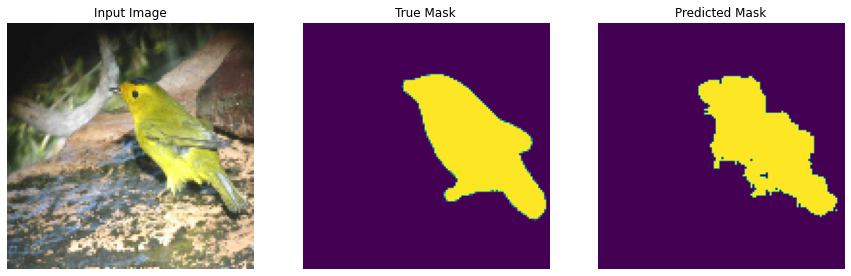

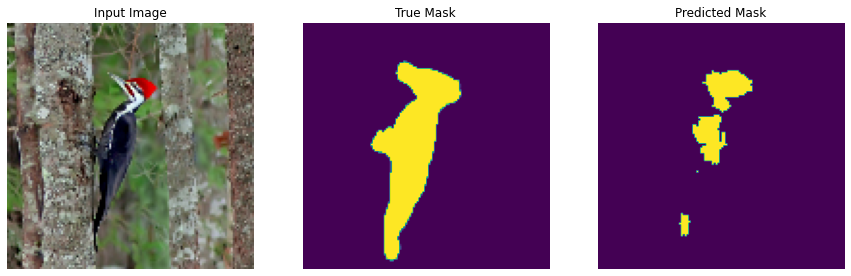

In [ ]:
show_predictions(test_dataset, 3)

Увеличение эпох выше 6 ухудшает результат, приводя к переобучению

## Изменим количество ядер

Увеличим вдвое

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(1024, 3),  # 4x4 -> 8x8
    pix2pix.upsample(512, 3),  # 8x8 -> 16x16
    pix2pix.upsample(256, 3),  # 16x16 -> 32x32
    pix2pix.upsample(128, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

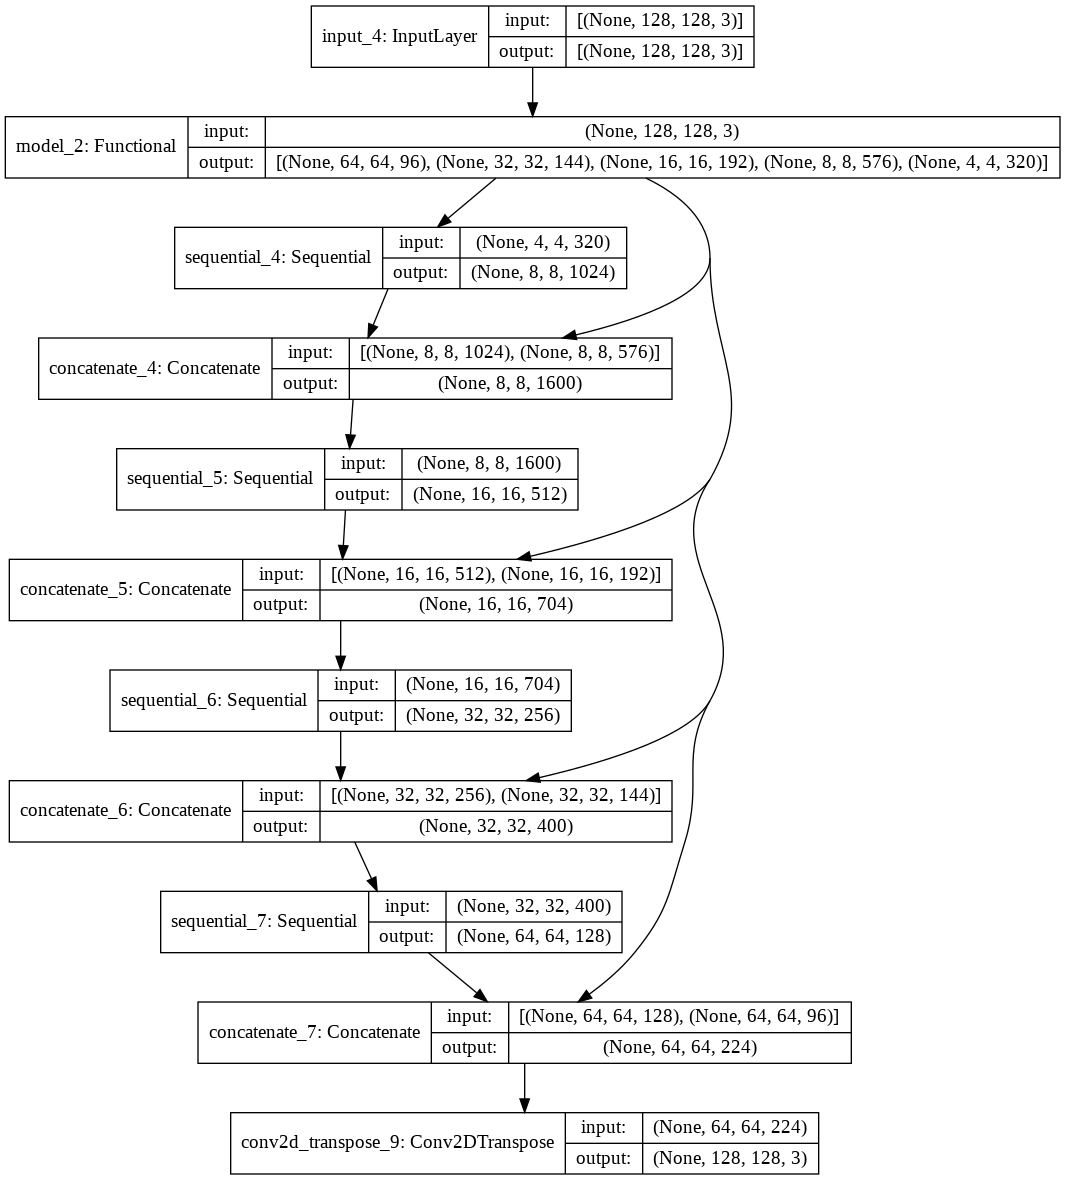

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

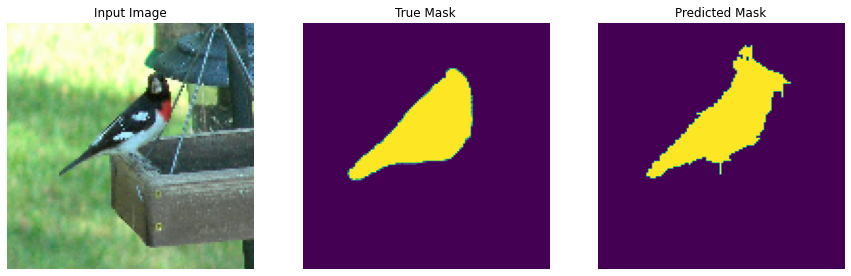


Sample Prediction after epoch 15



In [ ]:
EPOCHS = 15
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

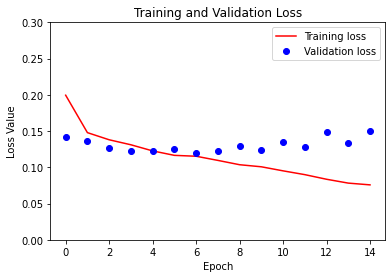

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.3])
plt.legend()
plt.show()

In [ ]:
loss

[0.19947797060012817,
 0.14785616099834442,
 0.13800859451293945,
 0.13110487163066864,
 0.12266284972429276,
 0.11650412529706955,
 0.11528696119785309,
 0.10955623537302017,
 0.10358357429504395,
 0.10073493421077728,
 0.09513533860445023,
 0.0899031013250351,
 0.08352389186620712,
 0.07821287959814072,
 0.07579118013381958]

In [ ]:
val_loss

[0.14127744734287262,
 0.13600896298885345,
 0.12641260027885437,
 0.12319304794073105,
 0.12272471189498901,
 0.12510892748832703,
 0.12010176479816437,
 0.12248571217060089,
 0.1295386701822281,
 0.12416224926710129,
 0.13494935631752014,
 0.12735067307949066,
 0.14828991889953613,
 0.13367150723934174,
 0.15078020095825195]

In [ ]:
val_accuracy = model_history.history['val_accuracy']
val_accuracy

[0.9395723938941956,
 0.940930962562561,
 0.9447296857833862,
 0.9466617703437805,
 0.9467397928237915,
 0.9470556378364563,
 0.948240339756012,
 0.9468783736228943,
 0.9452175498008728,
 0.9481660723686218,
 0.9477006196975708,
 0.9482600092887878,
 0.9455534219741821,
 0.9473604559898376,
 0.9465886950492859]

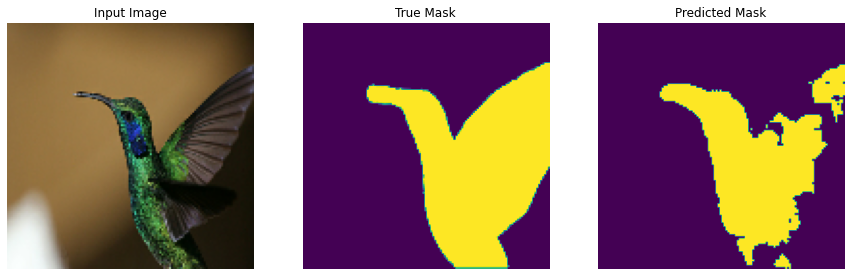

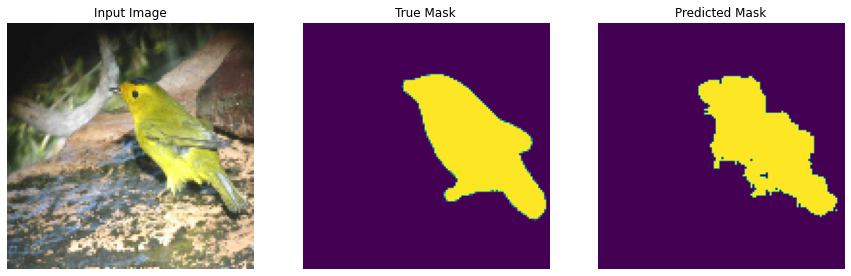

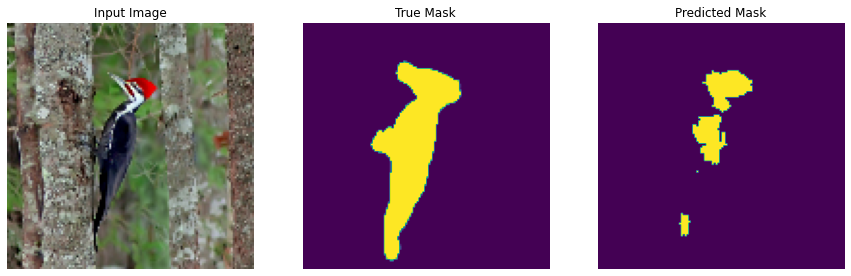

In [ ]:
show_predictions(test_dataset, 3)

Лучшее значения accuracy на тестовом наборе достигается на 7-й эпохе (0.9487). Оно ниже чем в предыдущем эксперементе. Дальше - переобучение 

Уменьшим количество ядер вдвое

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(256, 3),  # 4x4 -> 8x8
    pix2pix.upsample(128, 3),  # 8x8 -> 16x16
    pix2pix.upsample(64, 3),  # 16x16 -> 32x32
    pix2pix.upsample(32, 3),   # 32x32 -> 64x64
]

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

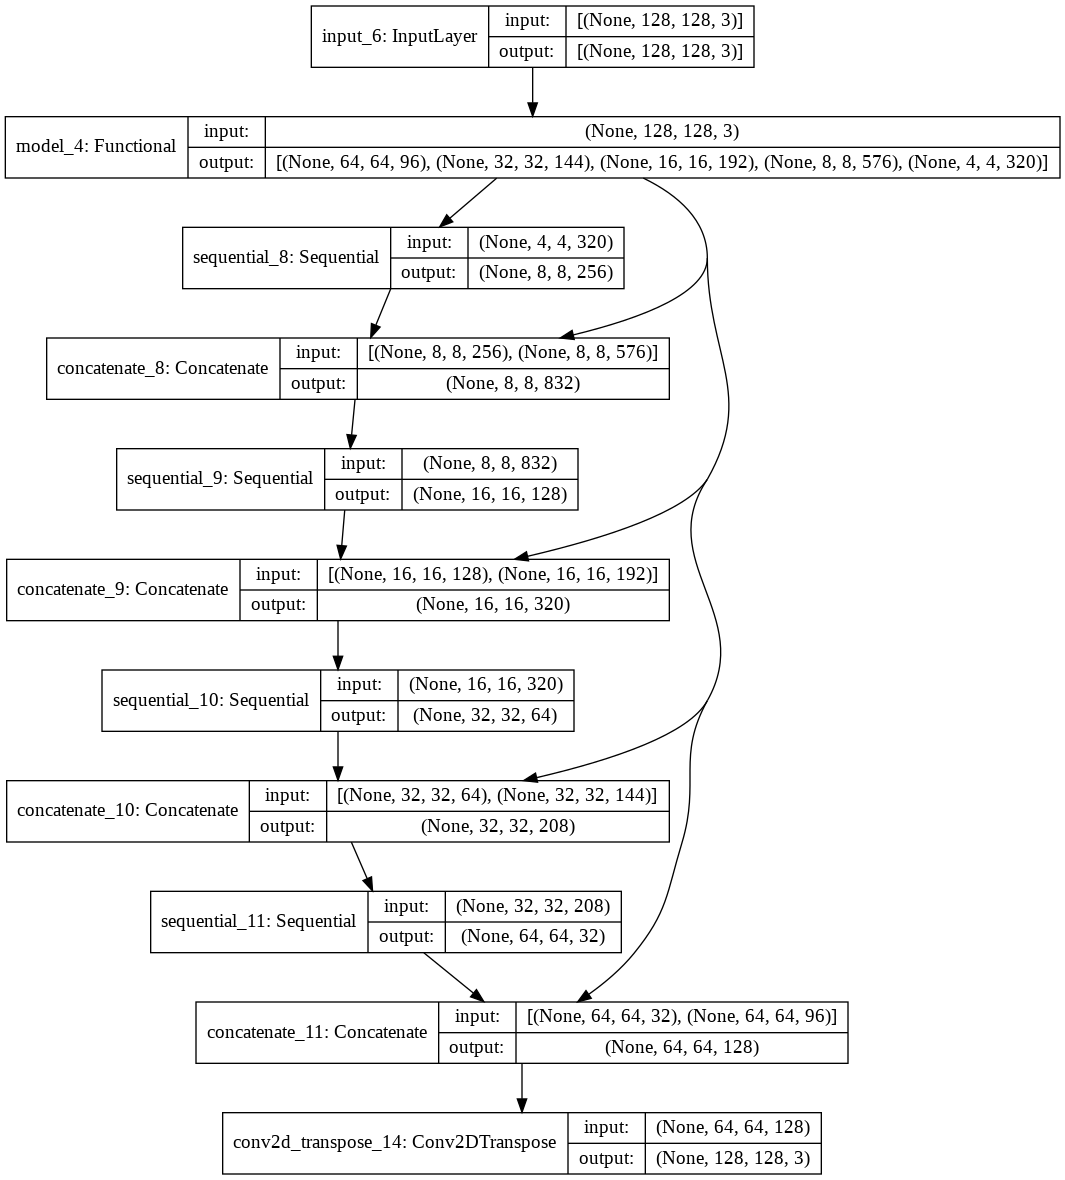

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

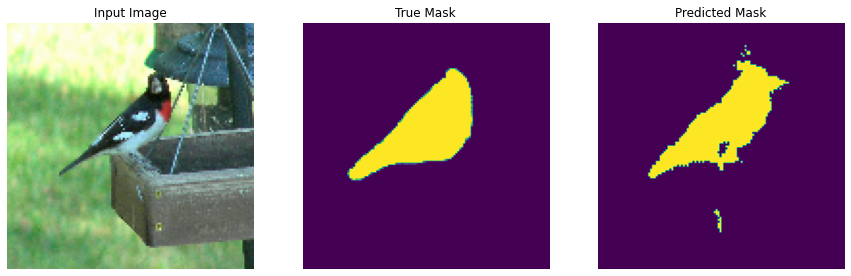


Sample Prediction after epoch 10



In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

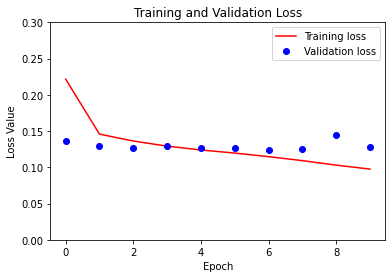

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.3])
plt.legend()
plt.show()

In [ ]:
loss

[0.22161811590194702,
 0.1458156555891037,
 0.1362714320421219,
 0.1292196810245514,
 0.12392477691173553,
 0.11965228617191315,
 0.1147366613149643,
 0.10920745134353638,
 0.10299257189035416,
 0.09755833446979523]

In [ ]:
val_loss

[0.13665318489074707,
 0.12950728833675385,
 0.12696632742881775,
 0.1294158399105072,
 0.12617506086826324,
 0.12640033662319183,
 0.1238170862197876,
 0.12479516863822937,
 0.14414304494857788,
 0.1279965043067932]

In [ ]:
val_accuracy = model_history.history['val_accuracy']
val_accuracy

[0.9425756931304932,
 0.944650411605835,
 0.9450364112854004,
 0.943503737449646,
 0.9452610611915588,
 0.945475697517395,
 0.9471414685249329,
 0.9468566179275513,
 0.940122663974762,
 0.9465805292129517]

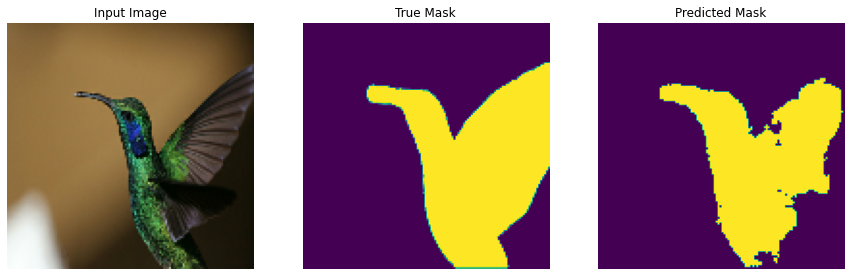

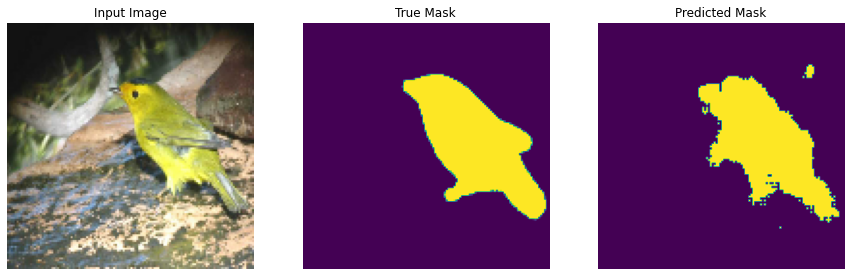

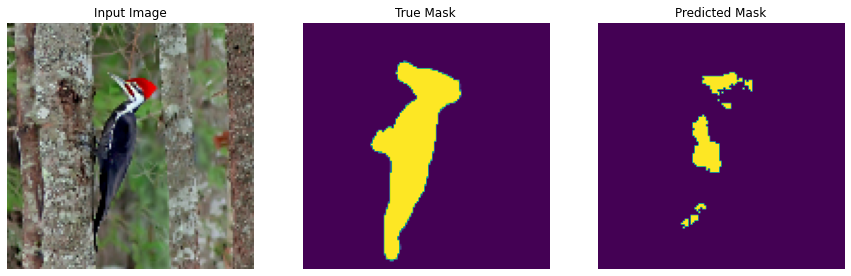

In [ ]:
show_predictions(test_dataset, 3)

Лучшее значения accuracy также как и в пердыдущем эксперементе на тестовом наборе достигается на 7-й эпохе (0.9471). Оно ниже чем в предыдущем эксперементе. Дальше - переобучение

## Уберем часть слоев сворачивания

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    print(skip.shape[1])
    x = up(x)
    if skip.shape[1] == 32:                               # Пропускаем один слой !!!
      continue
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

8
16
32
64


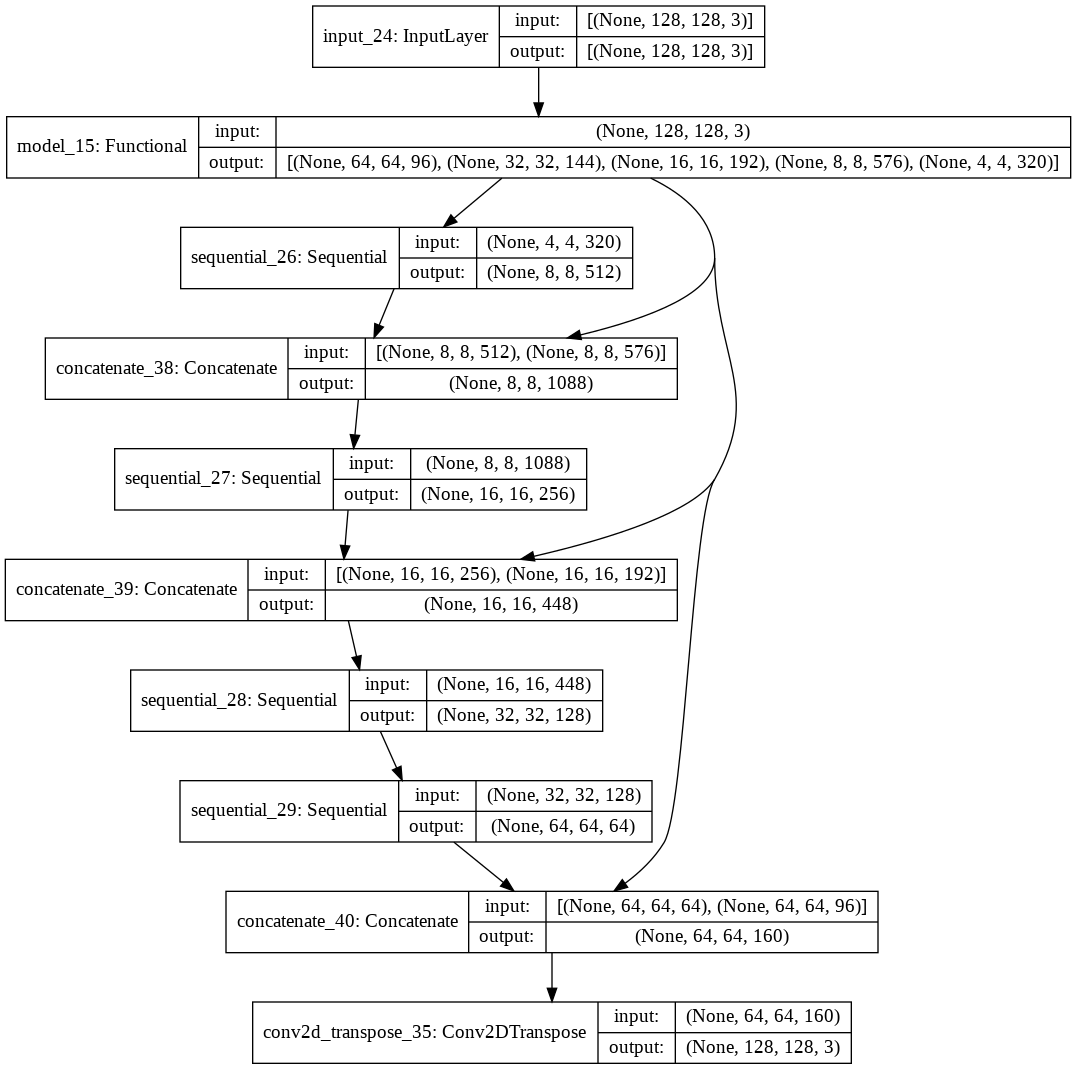

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

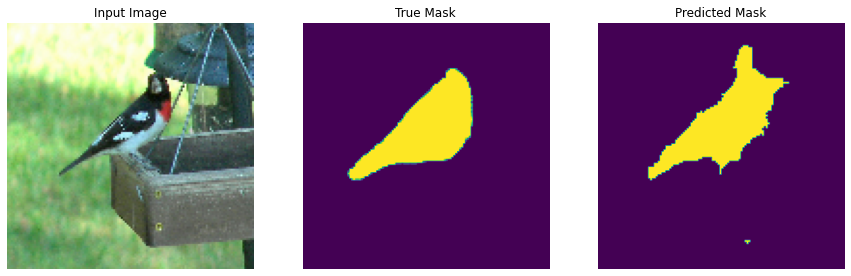


Sample Prediction after epoch 15



In [ ]:
EPOCHS = 15
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

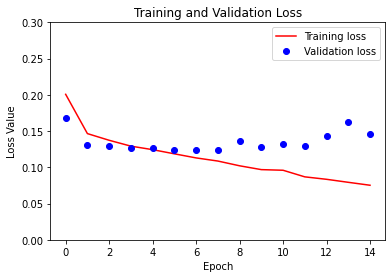

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.3])
plt.legend()
plt.show()

In [ ]:
loss

[0.20071804523468018,
 0.14651674032211304,
 0.13730646669864655,
 0.1292169839143753,
 0.12437035888433456,
 0.11861883848905563,
 0.11298254132270813,
 0.10865446925163269,
 0.10210460424423218,
 0.09682370722293854,
 0.09594465792179108,
 0.08684206753969193,
 0.08345983177423477,
 0.07931138575077057,
 0.07526325434446335]

In [ ]:
val_loss

[0.16813744604587555,
 0.1309526562690735,
 0.12897150218486786,
 0.1272072196006775,
 0.12714369595050812,
 0.12337490171194077,
 0.12371054291725159,
 0.12407787144184113,
 0.135902538895607,
 0.12741005420684814,
 0.13239869475364685,
 0.12997977435588837,
 0.14313988387584686,
 0.16203156113624573,
 0.14552560448646545]

In [ ]:
val_accuracy = model_history.history['val_accuracy']
val_accuracy

[0.9294313192367554,
 0.9433718323707581,
 0.9442784190177917,
 0.944438636302948,
 0.9430215358734131,
 0.9465614557266235,
 0.9464564919471741,
 0.9464515447616577,
 0.945674479007721,
 0.9474248290061951,
 0.9470884203910828,
 0.9463680386543274,
 0.9450121521949768,
 0.9462476372718811,
 0.9466145634651184]

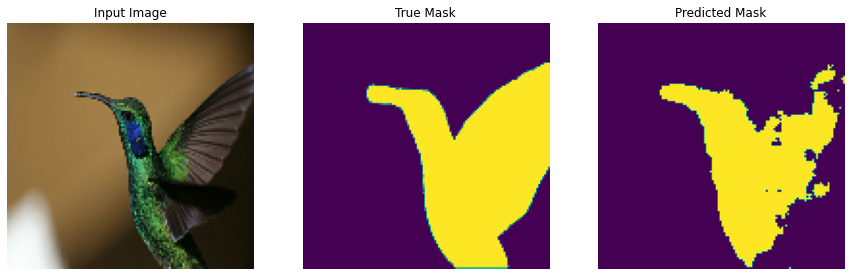

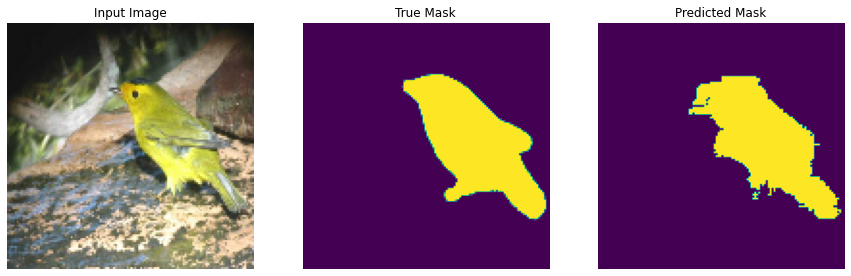

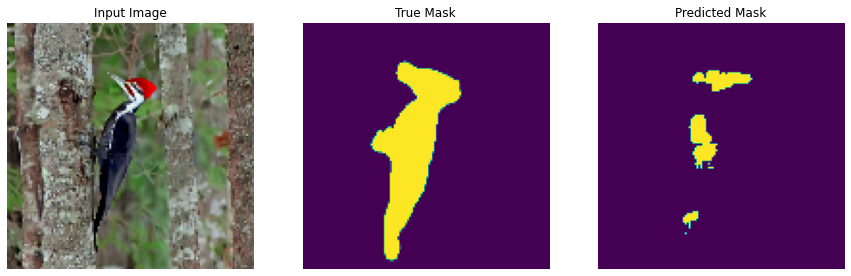

In [ ]:
show_predictions(test_dataset, 3)

Лучший результат смеился к 10-й эпохе, но он стал хуже, чем при начальной конфигурации

Уберем другой проброс

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    print(skip.shape[1])
    x = up(x)
    if skip.shape[1] == 8:                               # Пропускаем другой слой !!!
      continue
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

8
16
32
64


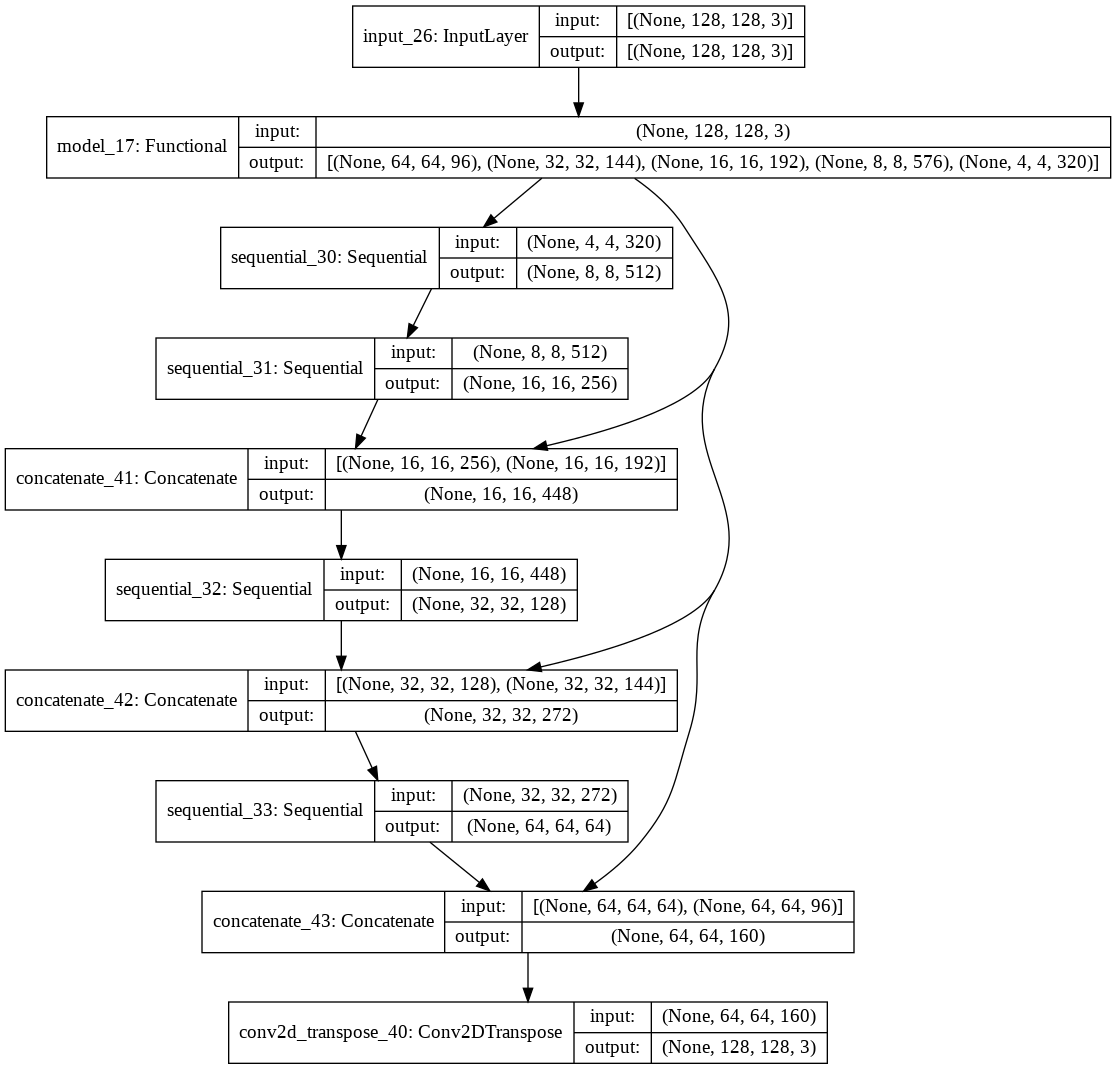

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

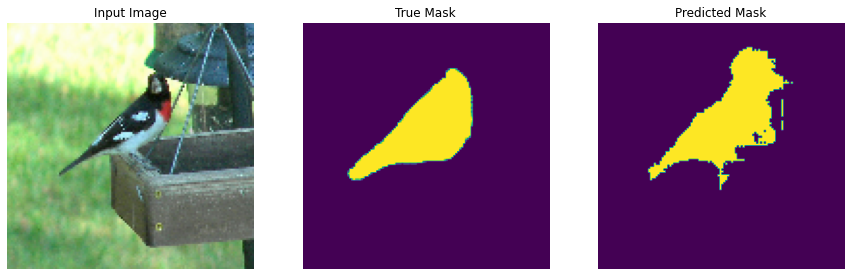


Sample Prediction after epoch 15



In [ ]:
EPOCHS = 15
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

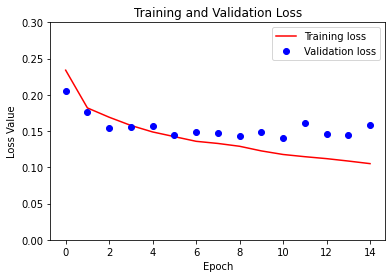

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.3])
plt.legend()
plt.show()

In [ ]:
loss

[0.23400387167930603,
 0.18194781243801117,
 0.16912353038787842,
 0.15778712928295135,
 0.14879658818244934,
 0.14233651757240295,
 0.1358897089958191,
 0.1329406201839447,
 0.12903332710266113,
 0.122650645673275,
 0.11771493405103683,
 0.11466143280267715,
 0.11198117583990097,
 0.10865968465805054,
 0.10508956015110016]

In [ ]:
val_loss

[0.20467548072338104,
 0.17592471837997437,
 0.15391390025615692,
 0.1550416201353073,
 0.1564398556947708,
 0.14489327371120453,
 0.1493726223707199,
 0.1479390412569046,
 0.14359354972839355,
 0.14938664436340332,
 0.1402537077665329,
 0.1612495481967926,
 0.14632917940616608,
 0.1448257863521576,
 0.15791891515254974]

In [ ]:
val_accuracy = model_history.history['val_accuracy']
val_accuracy

[0.9103713035583496,
 0.9229371547698975,
 0.9326461553573608,
 0.9324284195899963,
 0.9323272705078125,
 0.9373652338981628,
 0.9344788789749146,
 0.9359933733940125,
 0.9369128346443176,
 0.9358536005020142,
 0.9392797946929932,
 0.9333766102790833,
 0.9396938681602478,
 0.939721405506134,
 0.9394098520278931]

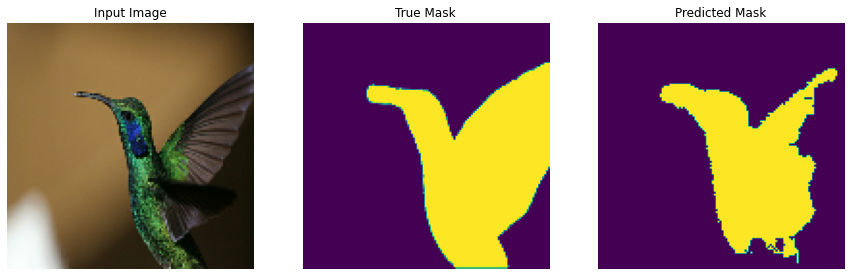

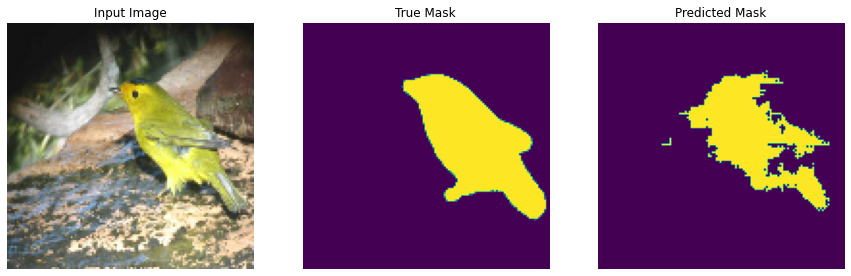

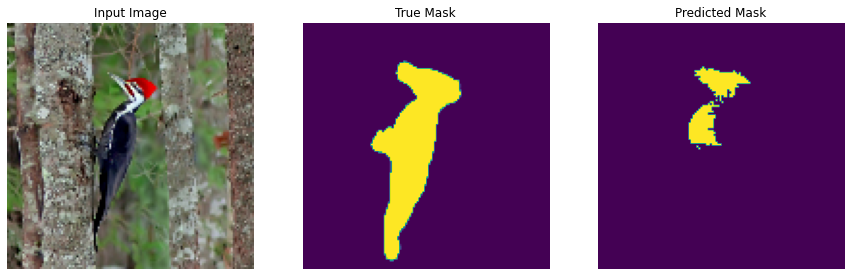

In [ ]:
show_predictions(test_dataset, 3)

Лучший результат сместился к 14-й эпохе, но он стал еще хуже